In [1]:
import sys
import os
sys.path.append(os.path.abspath('../quantum'))
import numpy as np
import matplotlib.pyplot as plt

#qiskit
from qiskit.providers.aer import Aer # call directly providers to avoid lazy loading of backend
from qiskit import QuantumCircuit, execute
from qiskit.quantum_info import state_fidelity, Statevector

# import basic plot tools
#import qiskit.visualization as vis
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit_textbook.tools import vector2latex
%matplotlib inline

# from quantum
import encoding as enc


In [2]:
import qiskit
qiskit.__version__

'0.19.1'

# amplitude encoding circuit

In [3]:
def normalize(v):
    return v / np.linalg.norm(v)

In [4]:
def get_encoding_circuit(*vv): # vv: tuple of vectors to be encoded
    
    sz = int(np.log2(len(vv[0])))
    
    qc = QuantumCircuit(len(vv)*sz)

    for i, v in enumerate(vv):
        qc.initialize(v, range(i*sz, (i+1)*sz))
    
    return qc

In [50]:
def run_circuit(qc):
    backend = Aer.get_backend('qasm_simulator') # we choose the simulator as our backend
    counts = execute(qc, backend, shots = 1000).result().get_counts() # we run the simulation and get the counts
    return counts

# real inputs

In [6]:
def normalize(v):
    return v / np.linalg.norm(v)

In [7]:
a11 = normalize(np.array([1,1]))
a1_1 = normalize(np.array([1,-1]))
a_11 = normalize(np.array([-1,1]))
a_1_1 = normalize(np.array([-1,-1]))

# amplitude encoding

In [8]:
qc_a11 = get_encoding_circuit(a11)
qc_a1_1 = get_encoding_circuit(a1_1)
qc_a_11 = get_encoding_circuit(a_11)
qc_a_1_1 = get_encoding_circuit(a_1_1)

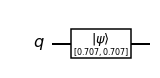

In [9]:
qc_a11.draw("mpl", style="bw")

## 4 real vectors

In [18]:
vv = np.stack([a11, a1_1, a_11, a_1_1])

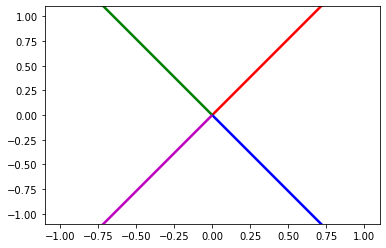

In [26]:
origin = np.array([[0, 0, 0, 0],[0, 0, 0, 0]]) # origin point

plt.quiver(*origin, vv[:,0], vv[:,1], color=['r','b','g','m'], scale=0.8)
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.show()

## 1,1

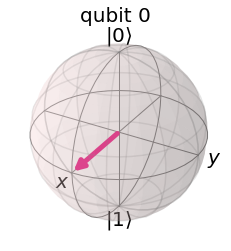

In [34]:
state11 = Statevector.from_instruction(qc_a11)
plot_bloch_multivector(state11)

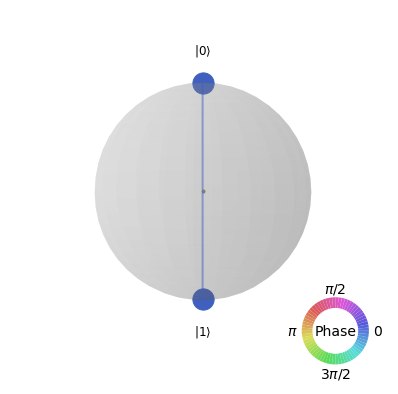

In [35]:
state11.draw(output='qsphere')

## 1,-1

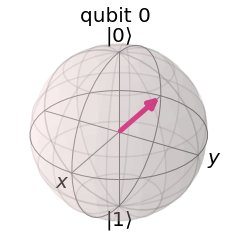

In [36]:
state1_1 = Statevector.from_instruction(qc_a1_1)
plot_bloch_multivector(state1_1)

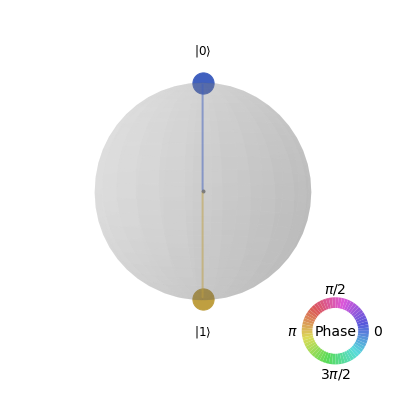

In [37]:
state1_1.draw(output='qsphere')

## -1,1

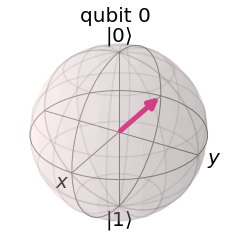

In [38]:
state_11 = Statevector.from_instruction(qc_a_11)
plot_bloch_multivector(state_11)

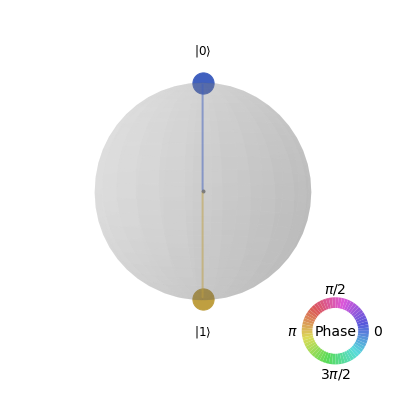

In [39]:
state_11.draw(output='qsphere')

## -1,-1

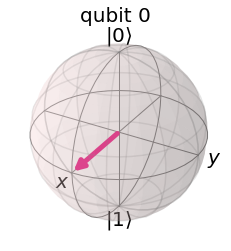

In [40]:
state_1_1 = Statevector.from_instruction(qc_a_1_1)
plot_bloch_multivector(state_1_1)

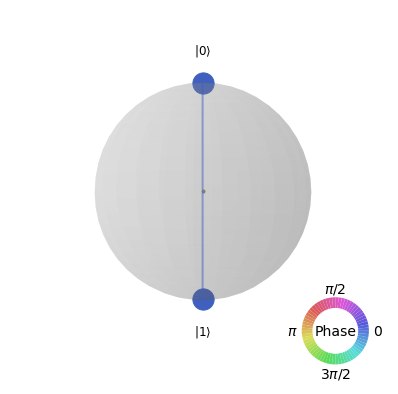

In [41]:
state_1_1.draw(output='qsphere')

# overlap

## swap test

In [57]:
def calculate_overlap(answer, state='0'):
    shots = answer[state] if len(answer) == 1 else answer['0']+answer['1']
    return np.abs(answer[state]/shots - 0.5) * 2

In [58]:
# basic swap test on amplitude encoded quantum states
def swap_test(v1, v2):
    
    # create circuit with n qubits and one classical bit for measurement
    # qubits: first: ancilla, second: input vector, third: cluster center
    #(for latent space in R^2: 1 (ancilla) + 1 (x1,x2 coords of input) + 1 (x1,x2 coords of cluster))
    n = int(np.log2(len(v1))) if len(v1) > 1 else 1
    qc = QuantumCircuit(n*2+1, 1, name="swap_test")

    # control qubit default 0
    # append first vector
    qc.append(v1, range(1,n+1))
    # append second vector
    qc.append(v2, range(n+1,n*2+1))
    
    qc.barrier()
    # apply hadamard to control
    qc.h(0)
    # swap pairwise qubits controlled on ancilla
    for i in range(n):
        qc.cswap(0,i+1,i+n+1)
    # apply second hadamard
    qc.h(0)
    # measure control qubit
    qc.measure(0,0)

    return qc

## 1,1 vs -1,1: fidelity = 0, swap test = 0% overlap 

In [66]:
print(state_fidelity(state11, state_11))

5.30532060329679e-32


In [67]:
calculate_overlap(run_circuit(swap_test(qc_a11, qc_a_11)))

0.006000000000000005

## 1,1 vs -1,-1: fidelity = 1, swap test = 100% overlap 

In [68]:
print(state_fidelity(state11, state_1_1))

1.0


In [69]:
calculate_overlap(run_circuit(swap_test(qc_a11, qc_a_1_1)))

1.0

## -1,1 vs 1,-1: fidelity = 1, swap test = 100% overlap 

In [70]:
print(state_fidelity(state_11, state1_1))

1.0


In [71]:
calculate_overlap(run_circuit(swap_test(qc_a_11, qc_a1_1)))

1.0

## -1,1 vs -1,-1: fidelity = 0, swap test = 0% overlap 

In [72]:
print(state_fidelity(state_11, state_1_1))

5.305320603296788e-32


In [73]:
calculate_overlap(run_circuit(swap_test(qc_a_11, qc_a_1_1)))

0.06599999999999995